In [149]:
import csv
from graph_tool.all import *
from datetime import datetime
from collections import defaultdict

In [150]:
post_graph = Graph()
user_graph = Graph()

post_topics = post_graph.new_vertex_property("string")
post_ids = post_graph.new_vertex_property("string")

interaction_topics = user_graph.new_edge_property("string")
user_ids = user_graph.new_vertex_property("string")

In [255]:
with open('gab.csv') as csv_file:
    #"$time;$id;$userID;$topicID;$parentID;$parentUserID"
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if line_count>50000:
            break
        time  = datetime.strptime(row[0][:-6], "%Y-%m-%dT%H:%M:%S").timetuple()
        pID   = row[1]
        uID   = row[2]
        tID   = row[3]
        ppID  = row[4]
        puID  = row[5]
        
        #Amend user graph
        if len(find_vertex(user_graph,user_ids,uID))==0:
            u1 = user_graph.add_vertex()
            user_ids[u1]=uID
        else: 
            u1 = find_vertex(user_graph,user_ids,uID)[0]
            
        if len(find_vertex(user_graph,user_ids,puID))==0 and int(puID)>0:
            u2 = user_graph.add_vertex()
            user_ids[u2]=puID
            if uID!=puID:
                e_user = user_graph.add_edge(u1, u2)
                interaction_topics[e_user]=tID
        else: 
            if int(puID)>0: 
                u2 = find_vertex(user_graph,user_ids,puID)[0]
                if uID!=puID:
                    e_user = user_graph.add_edge(u1, u2)
                    interaction_topics[e_user]=tID
        
        
        #Amend post graph
        if len(find_vertex(post_graph,post_ids,pID))==0:
            p1 = post_graph.add_vertex()
            post_ids[p1]=pID
            post_topics[p1]=tID
        else:
            p1 = find_vertex(post_graph,post_ids,pID)[0]
            
        if len(find_vertex(post_graph,post_ids,ppID))==0 and int(ppID)>0:
            p2 = post_graph.add_vertex()
            post_ids[p2]=ppID
            post_topics[p2]=tID
            e_post = post_graph.add_edge(p1,p2)
        else:
            if int(ppID)>0:
                p2 = find_vertex(post_graph,post_ids,ppID)[0]
                post_ids[p2]=ppID
                post_topics[p2]=tID
                e_post = post_graph.add_edge(p1,p2)
                
        line_count += 1
        #print('Processed '+str(line_count)+' lines.')

In [152]:
# Get rid of isolates in each graph, printing number of each

post_isolates = find_vertex(post_graph,"total",0)
print('Removing '+str(len(post_isolates))+' isolates from post-post graph')
for v in reversed(sorted(post_isolates)):
    post_graph.remove_vertex(v)
    
print('Remaining vertices: '+str(len(post_graph.get_vertices()))+'\n')
      
user_isolates = find_vertex(user_graph,"total",0)
print('Removing '+str(len(user_isolates))+' isolates from user-user graph')
for v in reversed(sorted(user_isolates)):
    user_graph.remove_vertex(v)
      
print('Remaining vertices: '+str(len(user_graph.get_vertices())))

Removing 4598 isolates from post-post graph
Remaining vertices: 5540

Removing 213 isolates from user-user graph
Remaining vertices: 267


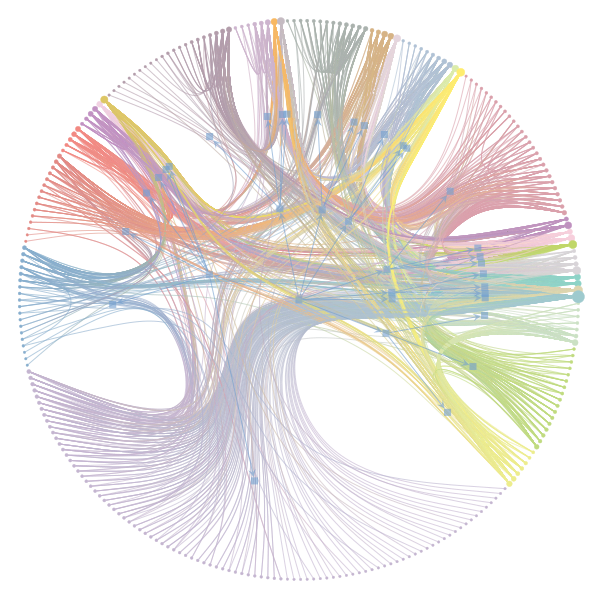

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f5afdc979e8, at 0x7f5b0c08e978>,
 <Graph object, directed, with 304 vertices and 303 edges at 0x7f5afdcb9390>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f5afdcb9390, at 0x7f5b0c08e278>)

In [153]:
# Display a hierarchically clustered view of user-user graph
state = minimize_nested_blockmodel_dl(user_graph)
state.draw()

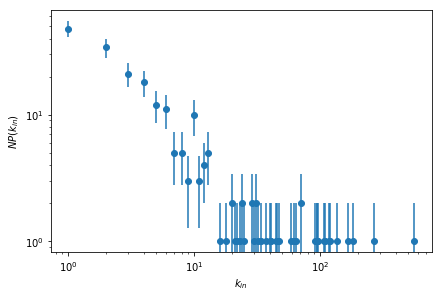

In [247]:
#Plot in-degree distribution of user graph
import matplotlib.pyplot as plt
import numpy as np

in_hist = vertex_hist(user_graph, "in")

y = in_hist[0]
err = np.sqrt(in_hist[0])
err[err >= y] = y[err >= y] - 1e-2

plt.figure(figsize=(6,4))
plt.errorbar(in_hist[1][:-1], in_hist[0], fmt="o", yerr=err,label="in")
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.tight_layout()
plt.xlabel("$k_{in}$")
plt.ylabel("$NP(k_{in})$")
plt.show()

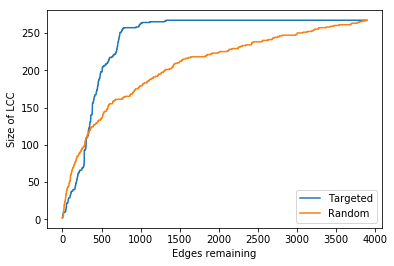

In [164]:
# Edge percolation (just for fun)
edges = sorted([(e.source(), e.target()) for e in user_graph.edges()], key=lambda e: e[0].out_degree()*e[1].out_degree())
sizes, comp = edge_percolation(user_graph, edges)
np.random.shuffle(edges)
sizes2, comp = edge_percolation(user_graph, edges)

plt.figure()
plt.plot(sizes, label='Targeted')
plt.plot(sizes2, label='Random')
plt.xlabel('Edges remaining')
plt.ylabel('Size of LCC')
plt.legend(loc='lower right')
plt.show()

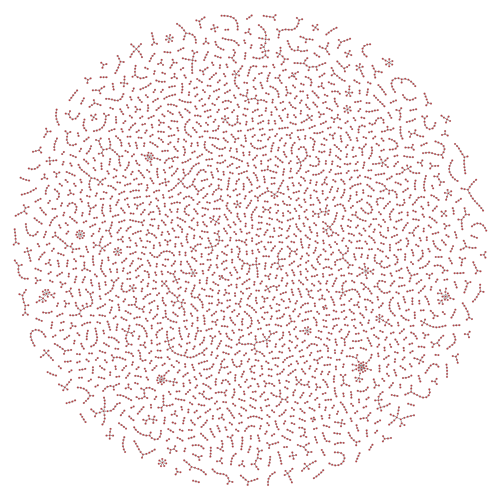

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f5b04a17320, at 0x7f5b04a0b048>

In [236]:
#Post-post graph viz

pos_post = sfdp_layout(post_graph)
graph_draw(post_graph,pos_post, output_size=(500,500))

In [259]:
from collections import Counter
post_graph.set_directed(False)
comp, hist = label_components(post_graph)

import powerlaw
results = powerlaw.Fit(list(hist))

hist_list = Counter(list(hist))
sorted(hist_list.items())

plt.figure(figsize=(6,4))
plt.scatter(*zip(*sorted(hist_list.items())),marker='o')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.tight_layout()
plt.xlabel("Post tree size")
plt.ylabel("Frequency")
plt.show()

ModuleNotFoundError: No module named 'powerlaw'

In [254]:
# Make user-topic graph of 1000 nodes worth
user_topic_graph = Graph()

ids = user_topic_graph.new_vertex_property("string")
is_user = user_topic_graph.new_vertex_property("bool")

plot_col = user_topic_graph.new_vertex_property('vector<double>')
user_topic_graph.vertex_properties['plot_col']=plot_col

with open('gab.csv','r') as f:
    csv_reader = csv.reader(f, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if len(user_topic_graph.get_vertices())>1000:
            break
        time  = datetime.strptime(row[0][:-6], "%Y-%m-%dT%H:%M:%S").timetuple()
        pID   = row[1]
        uID   = row[2]
        tID   = row[3]
        ppID  = row[4]
        puID  = row[5]
        
        if tID == "":
            continue
        
        if len(find_vertex(user_topic_graph,ids,uID))==0:
            u1 = user_topic_graph.add_vertex()
            ids[u1]=uID
            is_user[u1]=True
            plot_col[u1]=(1,0,0,1)
        else: 
            u1 = find_vertex(user_topic_graph,ids,uID)[0]
            
        if len(find_vertex(user_topic_graph,ids,tID))==0:
            u2 = user_topic_graph.add_vertex()
            ids[u2]=tID
            is_user[u2]=False
            plot_col[u2]=(0,0,0,1)
            e_user_topic = user_topic_graph.add_edge(u1,u2)
        else:
            u2 = find_vertex(user_topic_graph,ids,tID)[0]
            e_user_topic = user_topic_graph.add_edge(u1,u2)
            
        #print('Number of nodes: '+str(len(user_topic_graph.get_vertices())))
    f.close()
    


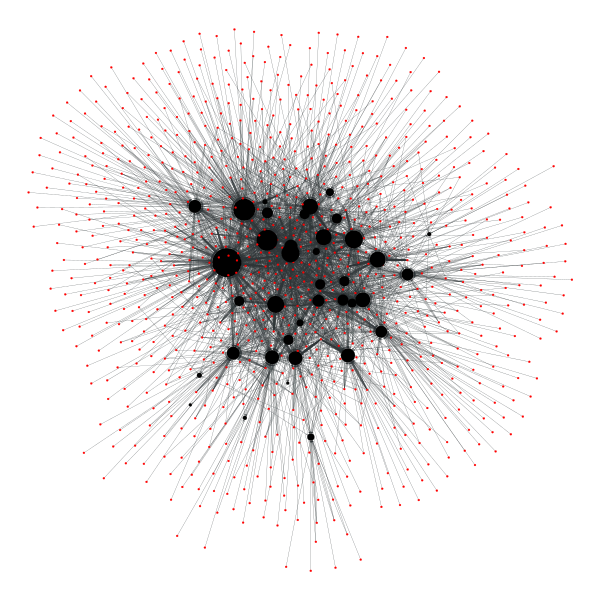

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f5afc9ecc88, at 0x7f5afc8fb5f8>

In [228]:
#Plot user-topic graph

deg = user_topic_graph.degree_property_map("in")
deg.a = 2 * (np.sqrt(deg.a) * 0.5 + 1)
graph_draw(user_topic_graph, 
           vertex_size=deg,
           vertex_color=user_topic_graph.vertex_properties['plot_col'],
           vertex_fill_color=user_topic_graph.vertex_properties['plot_col'])

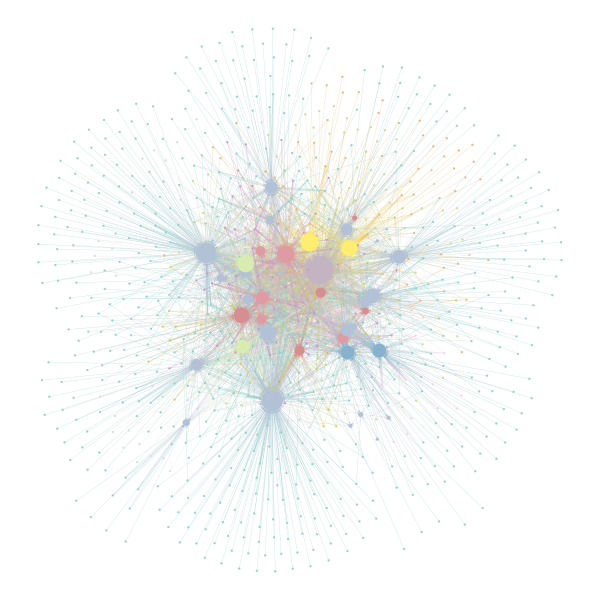

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f5afc9ecc88, at 0x7f5afca0cb70>

In [232]:
# User-topic graph coloured by SBM partition
state_2 = minimize_blockmodel_dl(user_topic_graph)
state_2.draw(vertex_size=deg)

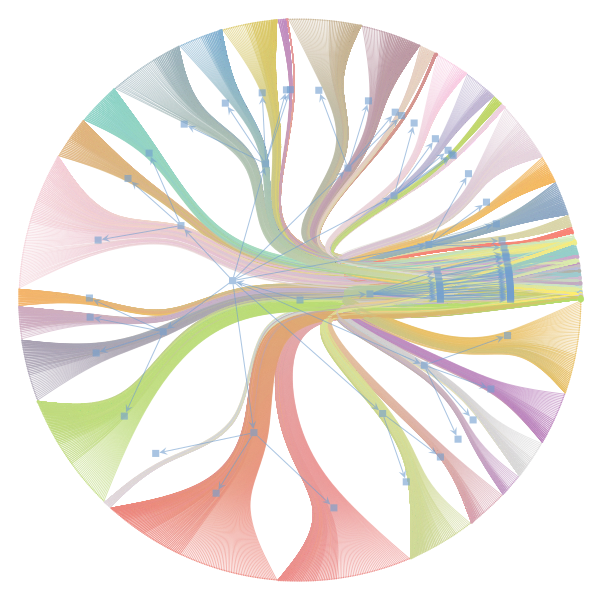

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f5afc9ecc88, at 0x7f5afcb59390>,
 <Graph object, directed, with 1080 vertices and 1079 edges at 0x7f5afcb4a4e0>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f5afcb4a4e0, at 0x7f5afcb4acf8>)

In [219]:
# Nested SBM hierarchical representation. NB this doesn't make too much sense since nodes are not same type.
state_3 = minimize_nested_blockmodel_dl(user_topic_graph)
state_3.draw()